In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[1:6, 1:6] = 1
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[1:3, 1:3] = 2
pred_masks[2:5, 8:10] = 2
pred_masks[8:12, 8:12] = 2
pred_masks[14:19, 14:19] = 2
pred_masks[10:15, 22:25] = 2

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[1:6, 1:6] = 1
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# Part Classes last
ref_masks[4:6, 4:6] = 2
ref_masks[14:19, 14:19] = 2

# Class definitions
stuff_cls_list = [4]
thing_cls_list = [1, 3]
part_cls_list = [2]

thing_cls_list = [1]

# Class definitions
stuff_cls_list = [4]
thing_cls_list = [1, 3]
part_cls_list = [2]

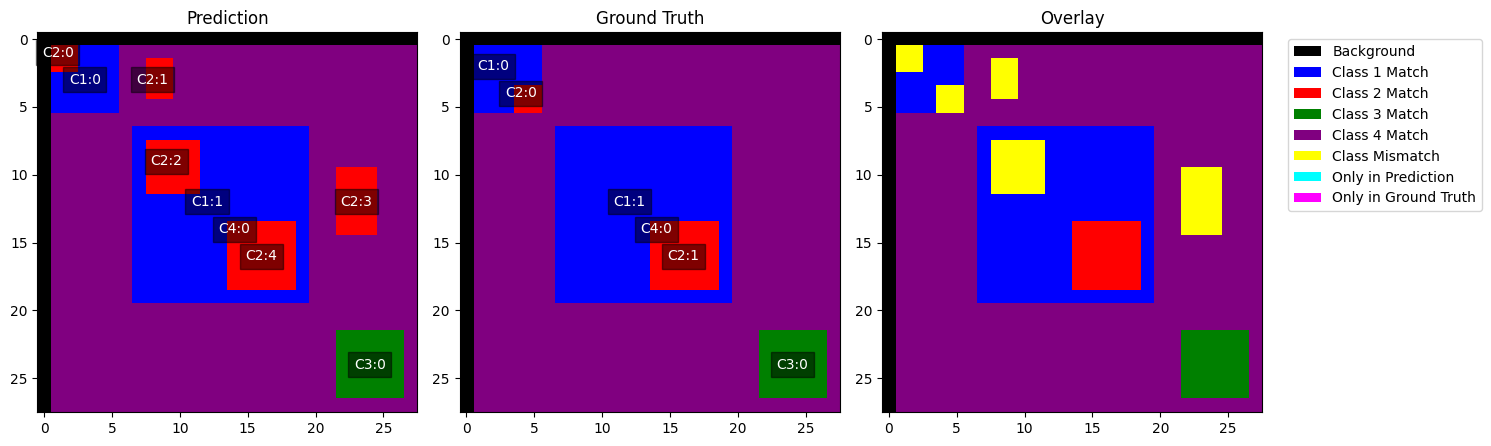

{'pred_instances': {1: 2, 2: 5, 3: 1, 4: 1},
 'gt_instances': {1: 2, 2: 2, 3: 1, 4: 1}}

In [2]:
# Improved plotting for multiple classes with proper instance counting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import ndimage
from matplotlib.patches import Patch

def plot_segmentation_comparison(pred, gt):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Determine the number of classes dynamically
    num_classes = max(np.max(pred), np.max(gt))
    
    # Generate colors dynamically - use a colormap for larger number of classes
    if num_classes <= 5:
        # Use discrete colors for small number of classes
        base_colors = ["black", "blue", "red", "green", "purple", "orange", "cyan", "magenta", "yellow", "lime"]
        colors = base_colors[:int(num_classes) + 1]
    else:
        # Use a continuous colormap with distinct colors for many classes
        cmap = plt.cm.get_cmap('tab20', num_classes + 1)
        colors = ["black"] + [cmap(i) for i in range(num_classes)]
    
    # Create custom colormap for prediction and ground truth
    cmap_custom = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(np.arange(-0.5, num_classes + 1.5, 1), cmap_custom.N)
    
    # Plot with improved colormaps
    ax[0].imshow(pred, cmap=cmap_custom, norm=norm)
    ax[0].set_title("Prediction")
    
    ax[1].imshow(gt, cmap=cmap_custom, norm=norm)
    ax[1].set_title("Ground Truth")
    
    # For overlay visualization - create dynamic categories
    overlay = np.zeros_like(pred, dtype=np.int32)
    
    # Class matches - preserve the class ID
    for class_id in range(1, int(num_classes) + 1):
        match_mask = (pred == class_id) & (gt == class_id)
        overlay[match_mask] = class_id
    
    # Special categories for visualization
    mismatch = np.zeros_like(pred, dtype=np.int32)
    mismatch[(pred != gt) & (pred > 0) & (gt > 0)] = num_classes + 1  # Different classes
    
    only_pred = np.zeros_like(pred, dtype=np.int32)
    only_pred[(pred > 0) & (gt == 0)] = num_classes + 2  # Only in prediction
    
    only_gt = np.zeros_like(pred, dtype=np.int32)
    only_gt[(pred == 0) & (gt > 0)] = num_classes + 3  # Only in ground truth
    
    # Combine for visualization
    overlay_viz = overlay.copy()
    overlay_viz[mismatch > 0] = mismatch[mismatch > 0]
    overlay_viz[only_pred > 0] = only_pred[only_pred > 0]
    overlay_viz[only_gt > 0] = only_gt[only_gt > 0]
    
    # Custom colormap for overlay - with additional colors for special categories
    overlay_colors = colors.copy()  # Start with class colors
    # Add colors for special categories
    special_colors = ["yellow", "cyan", "magenta"]
    overlay_colors.extend(special_colors)
    
    overlay_cmap = mcolors.ListedColormap(overlay_colors)
    overlay_norm = mcolors.BoundaryNorm(np.arange(-0.5, num_classes + 4.5, 1), overlay_cmap.N)
    
    ax[2].imshow(overlay_viz, cmap=overlay_cmap, norm=overlay_norm)
    ax[2].set_title("Overlay")
    
    # Add legend for overlay
    legend_elements = [Patch(facecolor="black", label="Background")]
    
    # Add class match legends
    for class_id in range(1, int(num_classes) + 1):
        legend_elements.append(Patch(facecolor=colors[class_id], label=f"Class {class_id} Match"))
    
    # Add special category legends
    legend_elements.extend([
        Patch(facecolor="yellow", label="Class Mismatch"),
        Patch(facecolor="cyan", label="Only in Prediction"),
        Patch(facecolor="magenta", label="Only in Ground Truth"),
    ])
    
    ax[2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left")
    
    # Process ground truth instances - Use a dictionary to store labeled instances by class
    gt_labeled = np.zeros_like(gt, dtype=np.int32)
    gt_instance_maps = {}  # Store instance maps by class
    gt_instance_count = {}  # Track instance count per class
    
    for class_id in range(1, int(num_classes) + 1):
        class_mask = gt == class_id
        if np.any(class_mask):
            # Label connected components for this class
            labeled, num_features = ndimage.label(class_mask)
            gt_instance_maps[class_id] = labeled.copy()
            gt_instance_count[class_id] = num_features
            
            # Store in the global labeled map (for visualization)
            for instance_id in range(1, num_features + 1):
                instance_mask = labeled == instance_id
                gt_labeled[instance_mask] = instance_id * 1000 + class_id  # Use a unique identifier
    
    # Process prediction instances - Use a dictionary to store labeled instances by class
    pred_labeled = np.zeros_like(pred, dtype=np.int32)
    pred_instance_maps = {}  # Store instance maps by class
    pred_instance_count = {}  # Track instance count per class
    
    for class_id in range(1, int(num_classes) + 1):
        class_mask = pred == class_id
        if np.any(class_mask):
            # Label connected components for this class
            labeled, num_features = ndimage.label(class_mask)
            pred_instance_maps[class_id] = labeled.copy()
            pred_instance_count[class_id] = num_features
            
            # Store in the global labeled map (for visualization)
            for instance_id in range(1, num_features + 1):
                instance_mask = labeled == instance_id
                pred_labeled[instance_mask] = instance_id * 1000 + class_id  # Use a unique identifier
    
    # Annotate instance numbers with better visibility
    # For ground truth
    for class_id in range(1, int(num_classes) + 1):
        labeled = gt_instance_maps.get(class_id, np.zeros_like(gt))
        for instance_id in range(1, np.max(labeled) + 1 if np.any(labeled) else 1):
            instance_mask = labeled == instance_id
            if np.any(instance_mask):
                y_coords, x_coords = np.where(instance_mask)
                y_center, x_center = int(np.mean(y_coords)), int(np.mean(x_coords))
                display_id = instance_id - 1  # Start from 0
                ax[1].text(
                    x_center,
                    y_center,
                    f"C{class_id}:{display_id}",
                    color="white",
                    fontsize=10,
                    ha="center",
                    va="center",
                    bbox=dict(facecolor="black", alpha=0.5),
                )
    
    # For prediction
    for class_id in range(1, int(num_classes) + 1):
        labeled = pred_instance_maps.get(class_id, np.zeros_like(pred))
        for instance_id in range(1, np.max(labeled) + 1 if np.any(labeled) else 1):
            instance_mask = labeled == instance_id
            if np.any(instance_mask):
                y_coords, x_coords = np.where(instance_mask)
                y_center, x_center = int(np.mean(y_coords)), int(np.mean(x_coords))
                display_id = instance_id - 1  # Start from 0
                ax[0].text(
                    x_center,
                    y_center,
                    f"C{class_id}:{display_id}",
                    color="white",
                    fontsize=10,
                    ha="center",
                    va="center",
                    bbox=dict(facecolor="black", alpha=0.5),
                )
    
    plt.tight_layout()
    plt.show()
    
    # Return instance counts for reporting
    return {
        "pred_instances": pred_instance_count,
        "gt_instances": gt_instance_count
    }

# Example usage:
plot_segmentation_comparison(pred_masks, ref_masks)

In [3]:
# Imports
import numpy as np
from panoptica import (
    InputType,
    Panoptica_Evaluator,
    ConnectedComponentsInstanceApproximator,
    # NaiveThresholdMatching,
    MaxBipartiteMatching,
)

# Dummy Case
pred_masks = np.zeros((28, 28))
ref_masks = np.zeros((28, 28))

# Stuff Classes first (lowest hirearchy)
pred_masks[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred_masks[1:6, 1:6] = 1
pred_masks[7:20, 7:20] = 1
pred_masks[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred_masks[1:3, 1:3] = 2
pred_masks[2:5, 8:10] = 2
pred_masks[8:12, 8:12] = 2
pred_masks[14:19, 14:19] = 2
pred_masks[10:15, 22:25] = 2

# Same ordering for ground truth
# Stuff Classes first
ref_masks[1:30, 1:30] = 4

# Thing Classes next
ref_masks[1:6, 1:6] = 1
ref_masks[7:20, 7:20] = 1
ref_masks[22:27, 22:27] = 3

# Part Classes last
ref_masks[4:6, 4:6] = 2
ref_masks[14:19, 14:19] = 2

# Class definitions
stuff_cls_list = [4]
thing_cls_list = [1, 3]
part_cls_list = [2]

thing_cls_list = [1]


from panoptica.utils.segmentation_class import SegmentationClassGroups
from panoptica.utils.label_group import LabelMergeGroup
from panoptica.utils.label_group import LabelPartGroup

The same labels [1, 2] were assigned to two different labelgroups, got SegmentationClassGroups = 
 - class_1 : LabelGroup [1], single_instance=False
 - class_2 : LabelGroup [2], single_instance=False
 - class_3 : LabelGroup [3], single_instance=False
 - class_4 : LabelGroup [4], single_instance=True
 - class_y : LabelMergeGroup [1, 2] -> ONE, single_instance=False
 - class_x : LabelPartGroup Thing: 1, Parts: [2], single_instance=False
Intended? This will evaluate the duplicate labels in both groups

Evaluating group class_1 with labels LabelGroup [1], single_instance=False


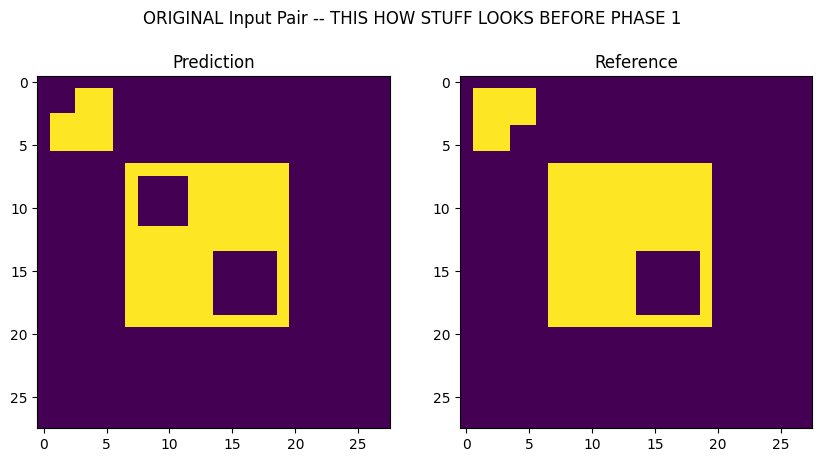

Evaluating group class_2 with labels LabelGroup [2], single_instance=False


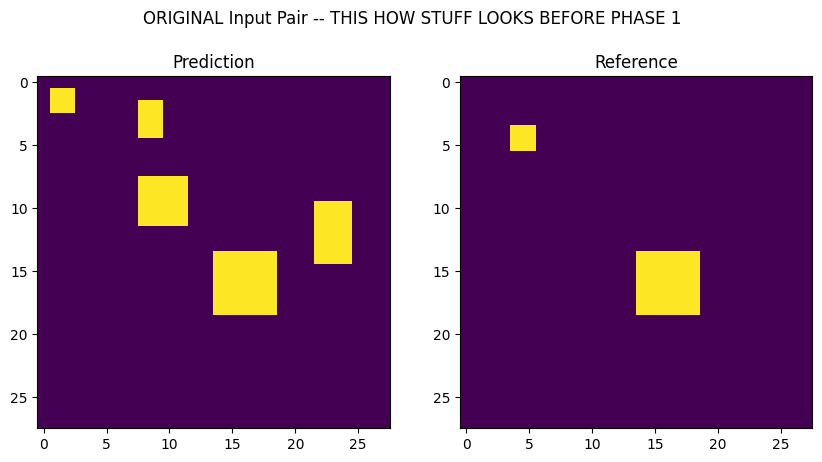

Evaluating group class_3 with labels LabelGroup [3], single_instance=False


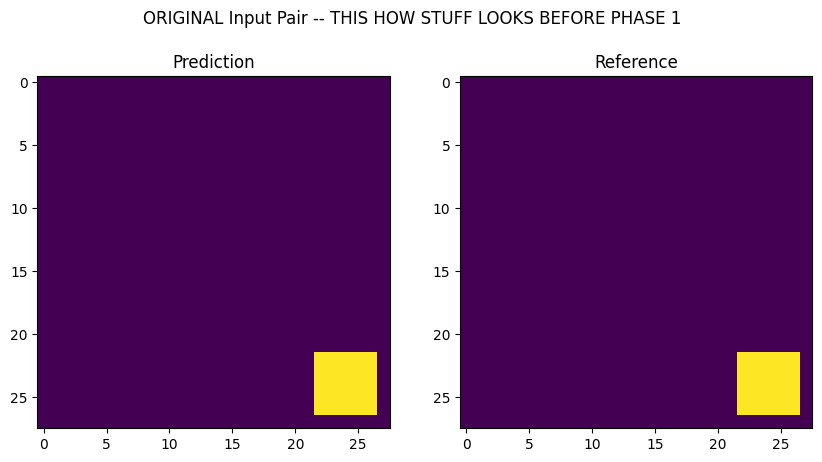

Evaluating group class_4 with labels LabelGroup [4], single_instance=True


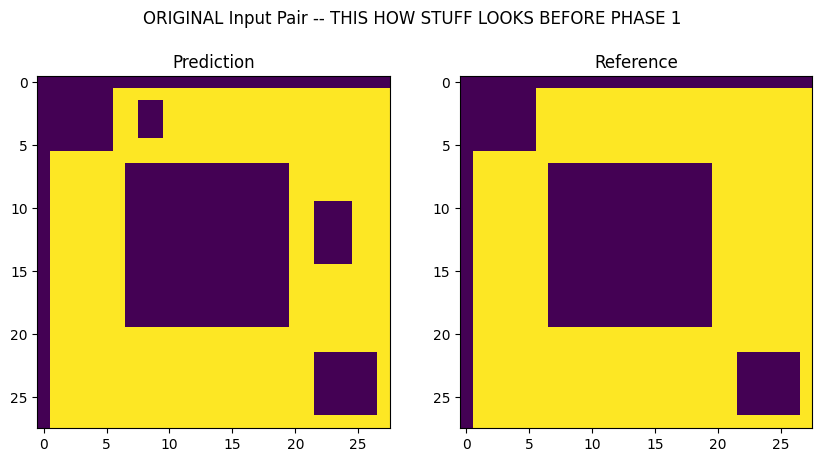

Evaluating group class_y with labels LabelMergeGroup [1, 2] -> ONE, single_instance=False


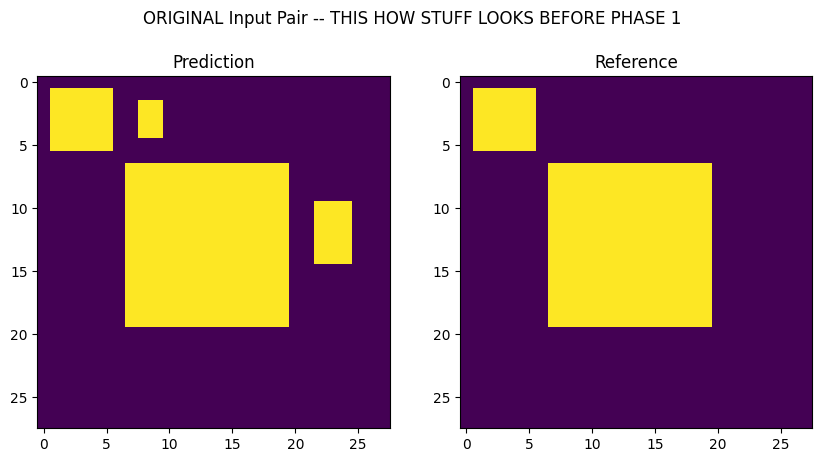

Evaluating group class_x with labels LabelPartGroup Thing: 1, Parts: [2], single_instance=False


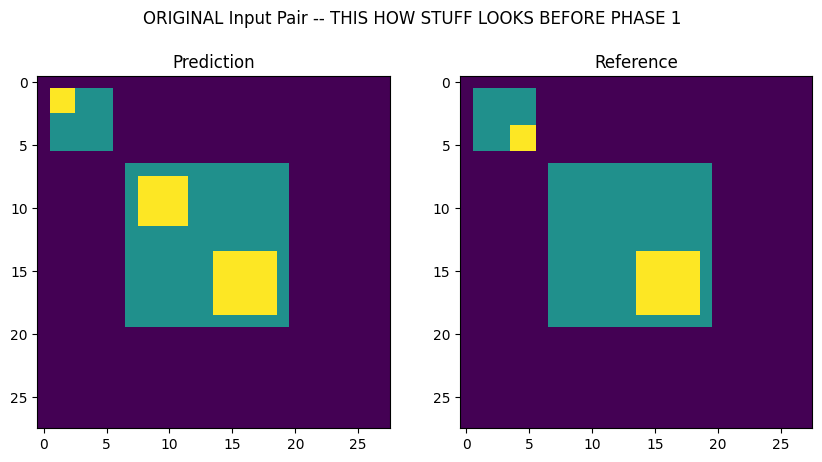

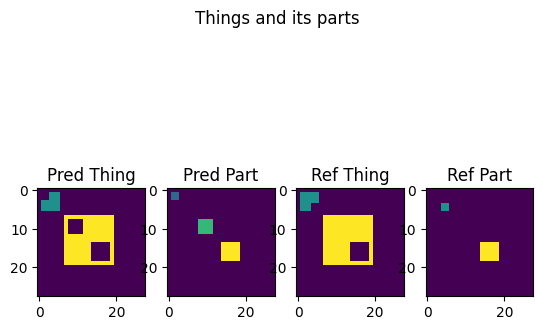

 We have entered a Part Class!
ORIG THING overlapping_labels [(1, 1), (2, 2)]
ORIG THING sorted_thing_pairs [(0.8888888888888888, (2, 2)), (0.68, (1, 1))]

For Pair (1,1):
For part Class 2:


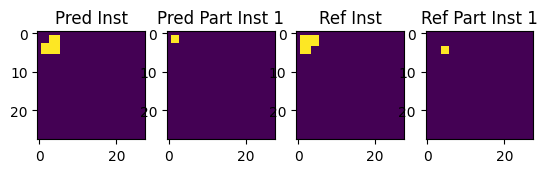

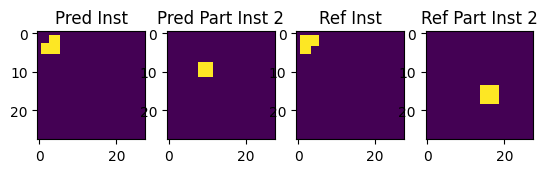

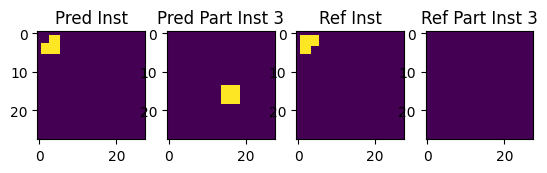

Matched Pred Part Instances: [0]
Matched Ref Part Instances: [0]


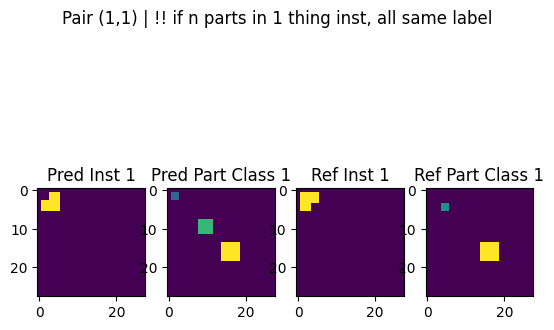

all part pairs [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
chosen part pairs [(0.0, (1, 1))]

For Pair (2,2):
For part Class 2:


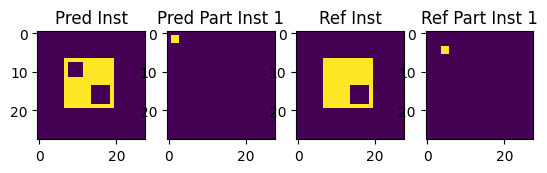

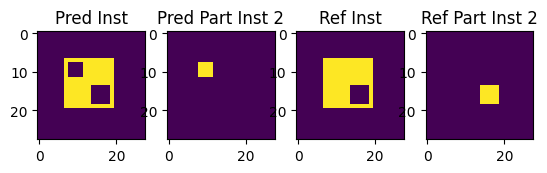

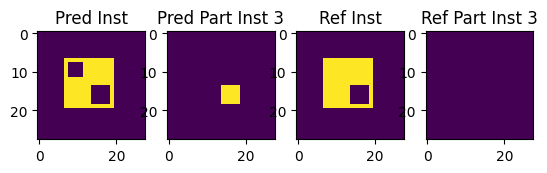

Matched Pred Part Instances: [1, 2]
Matched Ref Part Instances: [1]


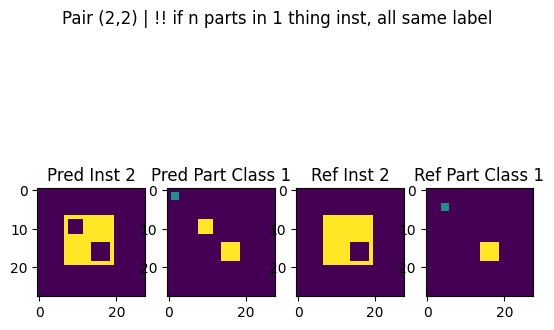

all part pairs [(1, 1), (1, 2), (2, 1), (2, 2)]
chosen part pairs [(0.6097560975609756, (2, 2))]

PART MATCHING COMPLETED
original thing pairs [(0.8888888888888888, (2, 2)), (0.68, (1, 1))]
updated thing pairs [(0.7493224932249323, (2, 2)), (0.34, (1, 1))]


In [4]:
# Using Part Group.
from panoptica.utils.label_group import LabelPartGroup

groups = {
    "class_1": (1, False),
    "class_2": (2, False),
    "class_3": (3, False),
    "class_4": (4, True),
    "class_y": LabelMergeGroup([1, 2], False),
    "class_X": LabelPartGroup([1, 2], False),
}
class_groups = SegmentationClassGroups(groups)
print()

pred_masks = pred_masks.astype(np.int32)
ref_masks = ref_masks.astype(np.int32)

evaluator = Panoptica_Evaluator(
    expected_input=InputType.SEMANTIC,
    instance_approximator=ConnectedComponentsInstanceApproximator(),
    instance_matcher=MaxBipartiteMatching(matching_threshold=0.5),
    segmentation_class_groups=class_groups,
)

results = evaluator.evaluate(pred_masks, ref_masks, verbose=False)

In [5]:
for class_name, result in results.items():
    print(f"\n--- {class_name} ---")
    result_dict = result.to_dict()
    # Filter the dictionary to show only the most important metrics
    important_metrics = ['tp', 'fp', 'fn', 'sq', 'rq', 'pq', 'sq_dsc', 'global_bin_dsc']
    filtered_dict = {k: round(v, 4) if isinstance(v, float) else v
                    for k, v in result_dict.items() if k in important_metrics}
    print(filtered_dict)


--- class_1 ---
{'tp': 2, 'fp': 0, 'fn': 0, 'rq': 1.0, 'sq': 0.7844, 'pq': 0.7844, 'sq_dsc': 0.8754, 'global_bin_dsc': 0.9236}

--- class_2 ---
{'tp': 1, 'fp': 4, 'fn': 1, 'rq': 0.2857, 'sq': 1.0, 'pq': 0.2857, 'sq_dsc': 1.0, 'global_bin_dsc': 0.5263}

--- class_3 ---
{'tp': 1, 'fp': 0, 'fn': 0, 'rq': 1.0, 'sq': 1.0, 'pq': 1.0, 'sq_dsc': 1.0, 'global_bin_dsc': 1.0}

--- class_4 ---
{'tp': 1, 'fp': 0, 'fn': 0, 'rq': 1.0, 'sq': 0.9588, 'pq': 0.9588, 'sq_dsc': 0.979, 'global_bin_dsc': 0.979}

--- class_y ---
{'tp': 2, 'fp': 2, 'fn': 0, 'rq': 0.6667, 'sq': 1.0, 'pq': 0.6667, 'sq_dsc': 1.0, 'global_bin_dsc': 0.9487}

--- class_x ---
{'tp': 1, 'fp': 1, 'fn': 1, 'rq': 0.5, 'sq': 0.827, 'pq': 0.4135, 'sq_dsc': 0.9053, 'global_bin_dsc': 0.9694}
